(logistic-reg-notebook)=
# Modello di regressione logistica

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(car)
    library(ltm)
    library(mirt)
    library(grid)
    library(TAM)
    # devtools::install_github("masurp/ggmirt")
    library(ggmirt)
    library(jtools)
    })

## Modello di regressione per variabili binarie

Il modello di regressione logistica viene utilizzato quando si è interessati a studiare la relazione tra una variabile dipendente dicotomica e una o più variabili indipendenti quantitative e/o qualitative. Supponiamo che la variabile risposta assuma due sole modalità, convenzionalmente chiamate successo e fallimento. Indichiamo $Y_i$ l'osservazione $i$-esima ($i=1, \dots, n$) sulla variabile risposta e supponiamo che le risposte siano indipendenti. Spesso ogni unità statistica è associata a un vettore ($x_1, \dots, x_p$) di variabili esplicative. Il nostro obiettivo è quello di studiare la relazione tra la probabilità di risposta

$$
Pr(Y=1 \mid X=x_i) \equiv Pr(Y_i) \equiv \pi_i
$$

e le variabili esplicative $x=x_1, \dots, x_p$. Considereremo qui il caso più semplice in cui vi è una sola variabile indipendente. Dato che il legame tra la $Y$ e la $X$ è probabilistico, la variabile dipendente è una variabile casuale Bernoulliana che assume i valori

$$
    y_i = \left\{ \begin{array}{ll}
        1 & \textrm{se l'$i$-esima osservazione corrisponde ad un ``successo''},\\
        0 & \textrm{altrimenti},
      \end{array} \right.
$$

  rispettivamente con probabilità $\pi$ e $1-\pi$:

$$
    \begin{array}{ll}
      P(Y_i = 1) = \pi,\\
      P(Y_i = 0) = 1-\pi.
    \end{array}
$$

Introduciamo il modello di regressione logistica considerando un problema rappresentativo e tentando innanzitutto di applicare ad esso il modello della regressione lineare.  I dati utilizzati si riferiscono a 100 volontari per cui l'età, `age`, è la variabile esplicativa, e `chd` è la variabile risposta che codifica la presenza `chd` = 1) o assenza (`chd` = 0) di sintomi di disturbi cardiaci. I dati sono contenuti nel file `chdage.dat` (Hosmer e Lemeshow, 2000).
   
Se la variabile dipendente è binaria, ha senso pensare alla
regressione come ad una *media condizionata*, come nel caso della
regressione lineare? Una media di valori 0 e 1 produce un valore della variabile
  dipendente che non può essere generato da nessuno degli 
    individui che sono stati intervistati. In riferimento alla popolazione, invece, la media condizionata $\mathbb{E}(Y \mid X=x)$ può essere intesa come la proporzione
  di valori 1 tra gli individui che hanno il punteggio $x$ sulla
  variabile esplicativa ($X$ = età) -- ovvero, la probabilità
  condizionata $\pi_i$ di osservare la presenza di sintomi di malattie
  coronariche in questo gruppo d'età:

$$
  \pi_i \equiv P(Y = 1 \mid X = x).
$$

Di conseguenza, il valore atteso diventa

$$
  \mathbb{E}(Y \mid x) = (1) \pi_i + (0) (1-\pi_i) = \pi_i.
$$

Se la variabile $X$ è discreta, condizionatamente a ciascun valore $X=x$, possiamo  calcolare nel campione la proporzione di valori $Y=1$. L'insieme di queste proporzioni condizionate corrisponde alla stima non parametrica della regressione della variabile dicotomica $Y$ sulla $X$. La stima della funzione di regressione può essere ottenuta mediante una tecnica di *smoothing* (cioè di regolarizzazione, di lisciamento), come indicato nella figura seguente.

In [2]:
chdage <- read.table("../data/logistic_reg/chdage_dat.txt", header = TRUE)
chdage |>
    head()

,id,age,chd
,<int>,<int>,<int>
1,1,20,0
2,2,23,0
3,3,24,0
4,5,25,1
5,4,25,0
6,7,26,0


`geom_smooth()` using formula = 'y ~ x'


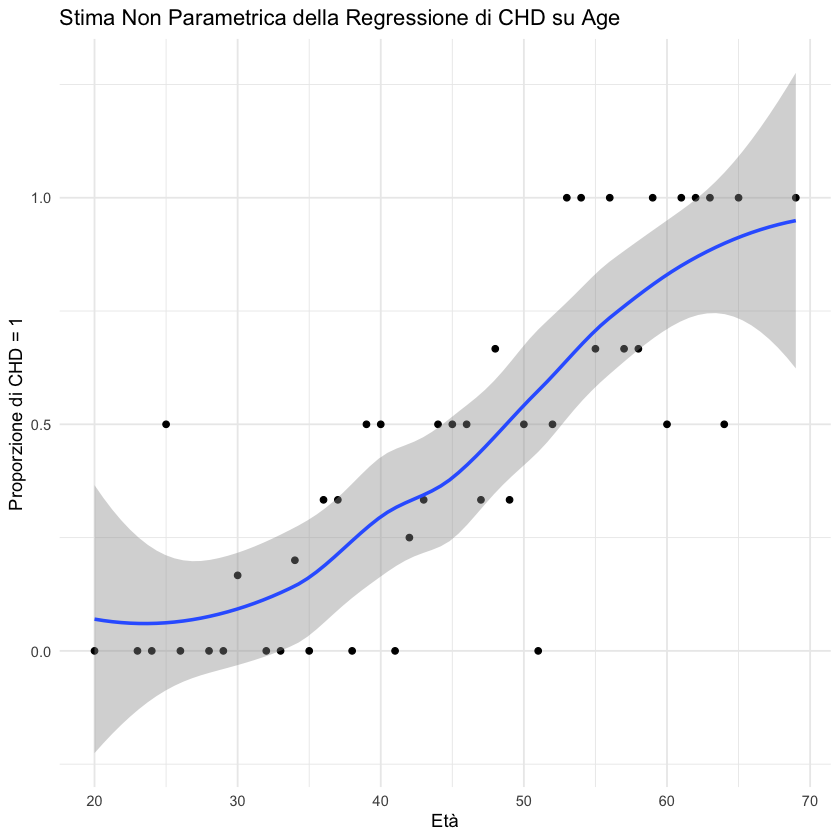

In [3]:
# Calcolo delle proporzioni di Y = 1 per ogni valore di X
prop_data <- chdage %>%
    group_by(age) %>%
    summarise(prop_chd = mean(chd))

# Grafico con smoothing
ggplot(prop_data, aes(x = age, y = prop_chd)) +
    geom_point() + # Mostra i punti di proporzione
    geom_smooth(method = "loess", span = 0.7) + # Regressione LOESS
    labs(
        title = "Stima Non Parametrica della Regressione di CHD su Age",
        x = "Età",
        y = "Proporzione di CHD = 1"
    ) +
    theme_minimal()

Per valori bassi della variabile `age` la proporzione condizionata di valori $Y=1$ è prossima allo 0. Per valori alti dell'età la proporzione di valori $Y=1$ è prossima a 1.0. A livelli di età intermedi, la curva di regressione non parametrica gradualmente approssima i valori 0 e 1 seguendo un andamento sigmoidale. 

Anche se nel caso presente la regressione non parametrica produce un risultato sensato, è utile rappresentare la dipendenza di $Y$ da $X$ con una semplice funzione, in particolare quando ci sono molteplici variabili esplicative.

## Modello lineare nelle probabilità

Iniziamo specificando un modello lineare con le solite assunzioni

$$
  Y_i = \alpha + \beta X_i + \varepsilon_i,
$$

dove $\varepsilon_i \sim \mathcal{N}(0, 1)$ e $\varepsilon_i$ e $\varepsilon_j$ sono indipendenti per $i \neq j$ (Figura~\ref{fig:lin_probmod}). Dato che $\mathbb{E}(Y_i) = \alpha + \beta X_i$, ne segue che

$$
  \pi_i = \alpha + \beta X_i.
$$

Questo modello si dice *modello lineare nelle probabilità* (*linear probability model*). Tale modo di procedere è però insoddisfacente perchè non dà alcuna garanzia che i valori predetti siano confacenti a probabilità, cioè compresi tra 0 e 1. Inoltre, non sarebbe opportuno usare il metodo dei minimi quadrati poichè in questo caso la varianza non è costante, ma è funzione della media e quindi funzione della variabile $X$.

### Normalità

Dato che $Y_i$ può assumere solo i valori 0 e 1, gli errori sono pure dicotomici e, dunque, non possono essere distribuiti normalmente. Se $Y_i=1$ con probabilità $\pi_i$ allora

$$
\begin{align}
\varepsilon_i = 1- \mathbb{E}(Y_i) = 1- (\alpha + \beta X_i) = 1 - \pi_i. \notag 
\end{align}
$$

Se $Y_i=0$ con probabilità $1-\pi_i$ allora

$$
    \begin{align}
      \varepsilon_i &= 0- \mathbb{E}(Y_i) = 0- (\alpha + \beta X_i) =
      - \pi_i. \notag
    \end{align}
$$

Se la numerosità del campione è sufficientemente grande, comunque, come conseguenza del teorema del limite centrale, l'assunzione di normalità non è critica per le stime dei minimi quadrati.

### Omoschedasticità

La varianza di $\varepsilon$ non è costante. Se l'assunzione di linearità è soddisfatta, allora $\mathbb{E}(\varepsilon_i)=0$. Utilizzando i risultati precedenti otteniamo

 $$
    \begin{align}
      \mathbb{V}(\varepsilon_i) &=  (1- \pi_i)^2\pi_i + (-\pi_i)^2(1-\pi_i) \notag \\
      &= (1-\pi_i)\left[ (1-\pi_i) \pi_i + \pi_i^2 \right]\notag\\
      &= (1 - \pi_i)\pi_i. \notag
    \end{align}
$$

L'eteroschedasticità degli errori è un problema per le stime dei minimi quadrati del modello lineare, ma solo se le probabilità $\pi_i$ sono prossime a 0 e 1.
   

### Linearità

Il maggiore inconveniente connesso all'adozione del modello lineare nelle probabilità deriva dal fatto che la stima della probabilità di successo, $P(\hat{Y}_i=1)=\hat{\pi}_i$,
non è necessariamente compresa nell'intervallo ($0,1$), ma può essere sia negativa sia maggiore di 1. Questo problema è evidente nella Figura~\ref{fig:lin_probmod}, in cui la retta dei minimi quadrati produce valori attesi $\hat{\pi}$ inferiori a 0 per bassi valori della variabile età e valori $\hat{\pi}$ superiori a 1 per valori di età alti.

## Constrained linear-probability model

Una possibile soluzione è quella di forzare $\pi$ nell'intervallo $(0, 1)$:

$$
\pi=
\begin{cases}
  0                           &\text{per $\alpha + \beta X$} < 0,\\
  \alpha + \beta X           &\text{per $0 \leq \alpha + \beta X \leq 1$},\\
  1 &\text{per $\alpha + \beta X > 1$.}
\end{cases}
$$

Il *constrained linear-probability model*  è però instabile in quanto dipende criticamente dai valori in cui $\pi$ assume i valori 0 e 1, dato che la retta $\pi = \alpha + \beta X$ è determinata da tali punti.
La stima del punto in cui $\pi = 0$ è determinata dal minore dei valori $X$ per cui $Y=1$;  allo stesso modo, la stima del punto in cui $\pi = 1$ è determinata dal maggiore dei valori $X$ per cui $Y=0$. Entrambi questi punti sono valori estremi, e dunque variano in
maniera sostanziale da campione a campione.  Inoltre, tendono adassumere valori tanto più estremi quanto più cresce la numerosità del campione. Inoltre, è difficile stimare i parametri del modello nel caso di $k \geq 2$ variabili esplicative. Infine, il brusco cambiamento dell'inclinazione della retta di  regressione in corrispondenza di $X=0$ e $X=1$ è poco realistico. Una funzione più "liscia" tra $\pi$ e $X$ è maggiormente plausibile.

## Regressione logistica

Il modo migliore per risolvere il problema del vincolo sulle probabilità consiste nello specificare dei modelli non per le probabilità, ma per delle loro trasformazioni che rimuovano tale vincolo. Se invece di specificare un modello lineare per la probabilità condizionata $\pi_i$ si specifica un modello lineare per il logaritmo degli odds

$$
  \eta_i = \log_e \frac{\pi_i}{1-\pi_i}= \alpha + \beta x_i,
$$

non sussistono problemi perché il logit $\eta$ è sempre un numero reale. Risulta così specificato un modello lineare per una trasformazione di $\pi$. La figura seguente è stata creata calcolando i \emph{logit empirici}, ovvero il logaritmo degli odds $\log_e(\hat{\pi}_i/(1-\hat{\pi}_i)$) in corrispondenza di 8 intervalli in cui è stata suddivisa la variabile "età". In questo caso è chiaro che vi è una relazione lineare tra i logit empirici e l'età.

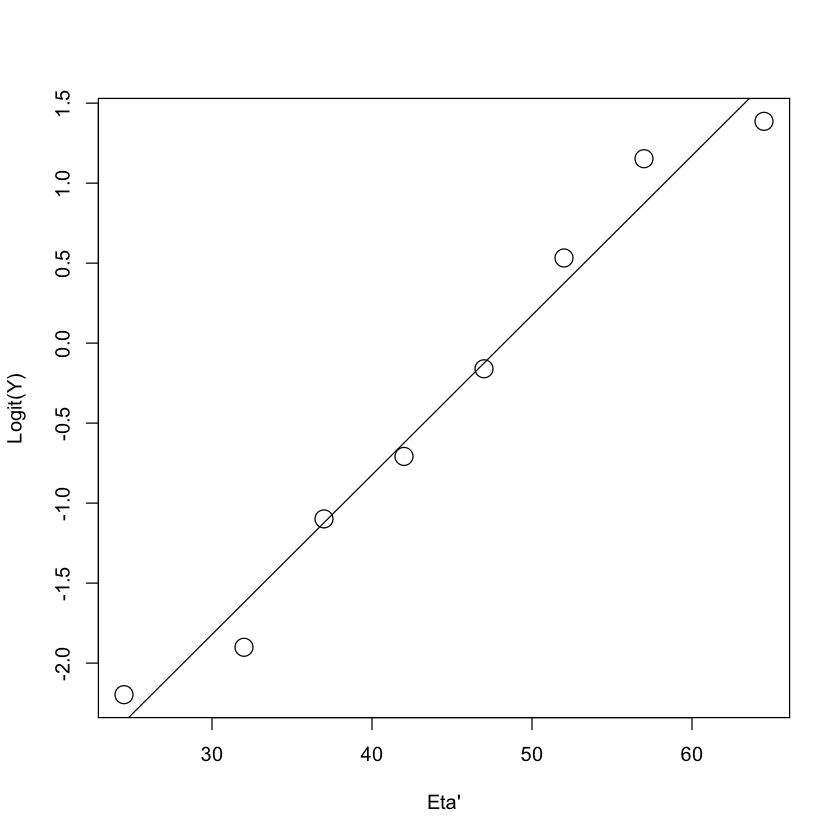

In [4]:
xc <- c(24.5, 32, 37, 42, 47, 52, 57, 64.5)
yc <- c(0.1, 0.13, 0.25, 0.33, 0.46, 0.63, 0.76, 0.8)
logit_y <- log(yc / (1 - yc))
fit2 <- lm(logit_y ~ xc)
plot(
    xc, logit_y,
    xlab = "Eta'", ylab = "Logit(Y)",
    main = "", type = "n"
)
points(xc, logit_y, cex = 2)
abline(fit2)

## Probabilità, odds e logit

La relazione tra probabilità, odds e logit è illustrata nella Tabella seguente. Si noti che, come la probabilità va a zero la probabilità si approssima a 1, l'odds tende a $+\infty$ e lo stesso accade al logit. Il logit così trasforma le probabilità dall'intervallo (0, 1) nell'intera linea dei numeri reali. Si noti che se la probabilità è 0.5, l'odds è 1 e il logit è 0. Logit negativi rappresentano probabilità minori di 0.5 e logit positivi rappresentano probabilità maggiori di 0.5.

| Probabilità | Odds               | logit   |
|-------------|--------------------|---------|
| 0.01        | 1/99 = 0.0101      | -4.60   |
| 0.05        | 5/95 = 0.0526      | -2.94   |
| 0.10        | 1/9 = 0.1111       | -2.20   |
| 0.30        | 3/7 = 0.4286       | -0.85   |
| 0.50        | 5/5 = 1            | 0.00    |
| 0.70        | 7/3 = 2.333        | 0.85    |
| 0.90        | 9/1 = 9            | 2.20    |
| 0.95        | 95/5 = 19          | 2.94    |
| 0.99        | 99/1 = 99          | 4.60    |


### Trasformazione inversa del logit

La trasformazione inversa del logit, detta *antilogit*, consente di trasformare i logit in probabilità:

$$
  \pi_i =\frac{e^{\eta_i}}{1+e^{\eta_i}}.
$$ 

Logit e probabilità possono dunque essere trasformati gli uni nelle altre. La trasformazione inversa del logit consente di specificare un modello non lineare per le probabilità $\pi_i$. Tale modello non lineare è detto *logit*, o modello di regressione logistica:

$$
  \pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \beta x_i}}{1+e^{\alpha + \beta x_i}}.
$$

La funzione logistica ben rappresenta l'andamento sigmoidale delle proporzioni di casi $Y=1$, ovvero $\hat{\pi}_i = E(Y \mid x_i)$ (le proporzioni di presenza di disturbi coronarici), in funzione di livelli crescenti della variabile `age`:

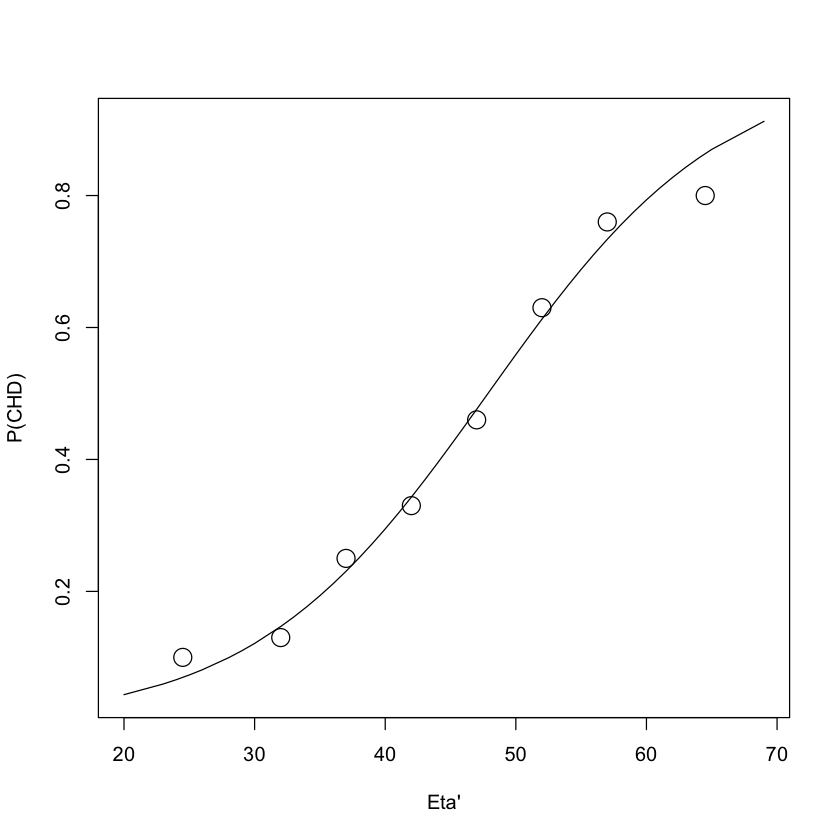

In [5]:
fm <- glm(chd ~ age, family = binomial(link = "logit"), data = chdage)
logit_hat <- fm$coef[1] + fm$coef[2] * chdage$age
pi_hat <- exp(logit_hat) / (1 + exp(logit_hat))

plot(chdage$age, pi_hat,
    xlab = "Eta'",
    ylab = "P(CHD)",
    main = "", type = "n"
)
lines(chdage$age, pi_hat)
xc <- c(24.5, 32, 37, 42, 47, 52, 57, 64.5)
yc <- c(0.1, 0.13, 0.25, 0.33, 0.46, 0.63, 0.76, 0.8)
points(xc, yc, cex = 2)

## Scala dei logit

Si consideri nuovamente il modello lineare nelle probabilità. Oltre al fatto che il predittore lineare $\bold{x}'_i \boldsymbol{\beta}$ può produrre dei valori esterni all'intervallo (0, 1), ci si deve anche chiedere se sia ragionevole  assumere un effetto lineare sulla scala delle probabilità.
  
Si consideri il seguente esempio. Un incentivo potrebbe produrre un aumento assoluto nella probabilità di intraprendere un'azione pari a dieci punti percentuali quando la probabilità dell'azione è pari a $0.5$. Tuttavia, l'incentivo non può avere un effetto pari a dieci punti percentuali se la probabilità dell'azione è uguale a $0.95$: non è dunque ragionevole pensare ad un effetto lineare nelle probabilità.

In contrasto, si supponga che l'effetto di un incentivo sia pari a $0.4$ sulla scala dei logit. Se la probabilità dell'azione è uguale a $0.5$, il logit è zero e un incremento sommativo di $0.4$ sulla scala dei logit produce una probabilità uguale a $0.6$ (dunque, l'effetto è pari a dieci punti percentuali, come prima). Se la probabilità dell'azione è $0.95$, però, il logitè quasi uguale a 3 e, aggiungendo $0.4$ si ottiene $0.97$ sulla scala delle probabilità, ovvero, un effetto di due punti percentuali. In conclusione, un effetto che è costante sulla scala dei logit si traduce in un effetto variabile nelle probabilità, ovvero, in un effetto che si aggiusta automaticamente in corrispondenza degli asintoti 0 e 1.

Possiamo dunque dire che il modello classico di regressione lineare non si può applicare nel caso di una variabile riposta binaria perché:

- $Y_i$ è binomiale con indice $n_i$ eventualmente uguale a uno nel caso individuale.  L'assunzione di normalità va dunque abbandonata.
- Le medie $E(Y_i)$ sono funzione delle probabilità di successo.  Usando la specificazione lineare, $\pi_i= \beta_0 + \beta_1 x_i$ c'è il rischio che si ottengano delle  probabilità stimate non comprese tra 0 e 1.
- Le varianze di $\varepsilon$ non sono costanti, ma dipendono dalla specificazione del modello per
le probabilità: $V(\varepsilon_i)=\pi_i (1-\pi_i)$.

Questo problemi si possono risolvere mediante l'applicazione di un modello lineare generalizzato che fa uso della funzione legame logistica. Il modello di regressione logistica fa parte di una classe più ampia di modelli, detta *Modelli Lineari Generalizzati* (*Genearalized Linear Models*, GLM) che includono anche il tradizionale modello di regressione lineare, insieme ad altri importanti modelli per  risposte qualitative.
      
- Il modello di regressione lineare viene utilizzato nel caso di una variabile dipendente continua, con variabili esplicative continue e/o qualitative.  
- Il modello di regressione logistica viene utilizzato nel caso di una variabile risposta binaria.
- Il modello di regressione di Poisson, detto modello loglineare, viene usato per modellare le frequenze di una tavola di contingenza.

Nei modelli lineari generalizzati vengono attenuate alcune ipotesi fondamentali nel modello lineare generale, ovvero 
- la *linearità* del modello di dipendenza in media di una variabile risposta da una o più variabili esplicative, 
- la *normalità*  della componente erratica,
- l'*omoschedasticità* delle osservazioni. 

Il GLM è costituito da 3 componenti:

1. una *componente aleatoria* che identifica il modello distributivo della variabile risposta $Y$;
2. una *componente sistematica* che specifica le variabili esplicative usate nella funzione predittiva lineare;
3. una *funzione legame* (*link function*) che mette in relazione $\mathbb{E}(Y)$ con la componente sistematica del modello.

| Componente aleatoria | Link       | Componente sistematica | Modello                |
|----------------------|------------|------------------------|------------------------|
| Gaussiana            | Identità   | Continua               | Regressione            |
| Gaussiana            | Identità   | Categoriale            | Analisi della varianza |
| Gaussiana            | Identità   | Mista                  | Analisi della covarianza |
| Binomiale            | Logit      | Mista                  | Regressione logistica  |
| Poisson              | Logaritmo  | Mista                  | Loglineare             |

## Componente sistematica

La componente sistematica mette in relazione un vettore ($\eta_1, \eta_2, \dots, \eta_k$) con le variabili esplicative mediante un modello lineare. Sia $X_{ij}$ il valore della $j$-esima variabile esplicativa ($j=1, 2, \dots, p$) per l'$i$-esima osservazione ($i=1, \dots, k$). Allora 

$$
\eta_i = \sum_j \beta_j X_{ij}.
$$

Questa combinazione lineare di variabili esplicative è chiamata il \emph{predittore lineare}.
Un $X_{ij}=1, \forall i$ viene utilizzato per il coefficiente dell'intercetta del modello (talvolta denotata da $\alpha$).

## Componente aleatoria

La  componente aleatoria del modello suppone l'esistenza di
  $k$ osservazioni indipendenti $y_1, y_2, \dots, y_k$, ciascuna delle
  quali viene trattata come la realizzazione di una variabile casuale
  $Y_i$. Si assume che $Y_i$ abbia una distribuzione binomiale:

$$
Y_i \sim Bin(n_i, \pi_i)
$$

con parametri $n_i$ e $\pi_i$. Per dati individuali (uno per ciascun valore $x_i$), $n_i=1,
    \forall i$.
  
## Funzione legame

La  funzione legame $g(\cdot)$  mette in relazione il valore atteso della variabile risposta $Y_i$ con la componente sistematica $\eta_i$ del modello. Abbiamo visto che $\mathbb{E}(Y_i)=\pi_i$.
Che relazione c'è tra $\pi_i$ e il predittore lineare $\eta_i= \alpha + \sum_j  \beta_j X_{ij}$? 
La risposta a questa domanda è data dalla funzione legame:

$$
\eta_i = g(\pi_i) = \ln{\frac{\pi_i}{1-\pi_i}}
$$

Si noti che la funzione legame non trasforma la variabile risposta $Y_i$ ma bensì il suo valore atteso $\pi_i$.

La funzione legame è invertibile: anziché trasformare il valore atteso nel predittore lineare si può trasformare il predittore lineare nel valore atteso $\pi_i$:

$$
\pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \sum_j  \beta_j X_{ij}}}{1+e^{\alpha + \sum_j  \beta_j X_{ij}}}.
$$

Si ottiene così un modello non lineare per le probabilità $\pi_i$.

## Regressione logistica con R

La stima dei parametri del modello di regressione logistica per i dati in esame si ottiene in R utilizzando la funzione `glm()`: 

In [6]:
fm <- glm(chd ~ age,
    family = binomial(link = "logit"),
    data = chdage
)

Si noti che è necessario specificare sia la funzione teorica della componente erratica del modello, sia la funzione legame. L'output della funzione `glm()` può essere visualizzato utilizzando  `summary()`:

In [7]:
summary(fm) |>
    print()


Call:
glm(formula = chd ~ age, family = binomial(link = "logit"), data = chdage)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.30945    1.13365  -4.683 2.82e-06 ***
age          0.11092    0.02406   4.610 4.02e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 136.66  on 99  degrees of freedom
Residual deviance: 107.35  on 98  degrees of freedom
AIC: 111.35

Number of Fisher Scoring iterations: 4



Per i dati dell'esempio, le probabilità predette sono uguali a

$$
\hat{\pi}(x)=\frac{e^{-5.309 + 0.111 \times {\tt age}}}{1+e^{-5.309 + 0.111 \times {\tt age}}}.
$$

I logit stimati sono dati dall'equazione 

$$
\hat{\eta}(x)=-5.309 + 0.111 \times {\tt age}.
$$


## Interpretazione dei Coefficienti

Il modello di regressione logistica può essere interpretato focalizzandosi sui coefficienti di regressione. Nel modello di regressione logistica la probabilità di avere la malattia coronarica (CHD) è prevista in base all'età.

### Interpretazione sulla Scala dei Log-Odds

1. **Intercetta (-5.30945):**
   - Questo valore rappresenta il log-odds di CHD quando l'età è 0 (anche se questo non è utile nel mondo reale).
   - Un valore negativo indica che, all'età di 0 anni, la probabilità di CHD è molto bassa.

2. **Coefficiente di Età (0.11092):**
   - Questo coefficiente indica la variazione del log-odds di CHD per ogni incremento di un anno di età.
   - Un valore positivo suggerisce che, man mano che l'età aumenta, aumenta anche la probabilità di CHD.

### Interpretazione nei Termini dell'Odds Ratio

L'odds ratio può essere calcolato esponenziando il coefficiente di età:

$$ 
\text{Odds Ratio per Età} = e^{0.11092}.
$$

Questo valore indica quanto cambiano le probabilità (odds) di CHD per ogni anno in più di età. Se l'odds ratio è maggiore di 1, significa che c'è un aumento delle probabilità; se è inferiore a 1, significa che c'è una diminuzione.

- **Esempio con il Coefficiente di Età:**
  - Posto che l'odds ratio calcolato per l'età è 1.12, possiamo interpretarlo come segue: "Per ogni anno aggiuntivo di età, l'odds di avere CHD aumenta del 12%."

L'interpretazione in termini di odds ratio è più intuitiva rispetto al log-odds, poiché fornisce una misura relativa del cambiamento nel rischio.

### Interpretazine nei Termini delle Probabilità Predette

L'ultimo e più raccomandato modo di interpretare i coefficienti del modello di regressione logistica consiste nel calcolo delle probabilità predette dell'evento di interesse. Rispetto ai coefficienti di regressione e agli odds ratio, le probabilità predette sono sostanzialmente più interpretabili.

Ad esempio, nello studio sulla probabilità di avere una malattia coronarica (CHD) in base all'età, anziché interpretare l'effetto dell'età sui log-odds di CHD, si può calcolare direttamente la probabilità predetta di CHD per persone di età diverse. Questo fornisce una rappresentazione più chiara e diretta di come il rischio di CHD cambia con l'età.

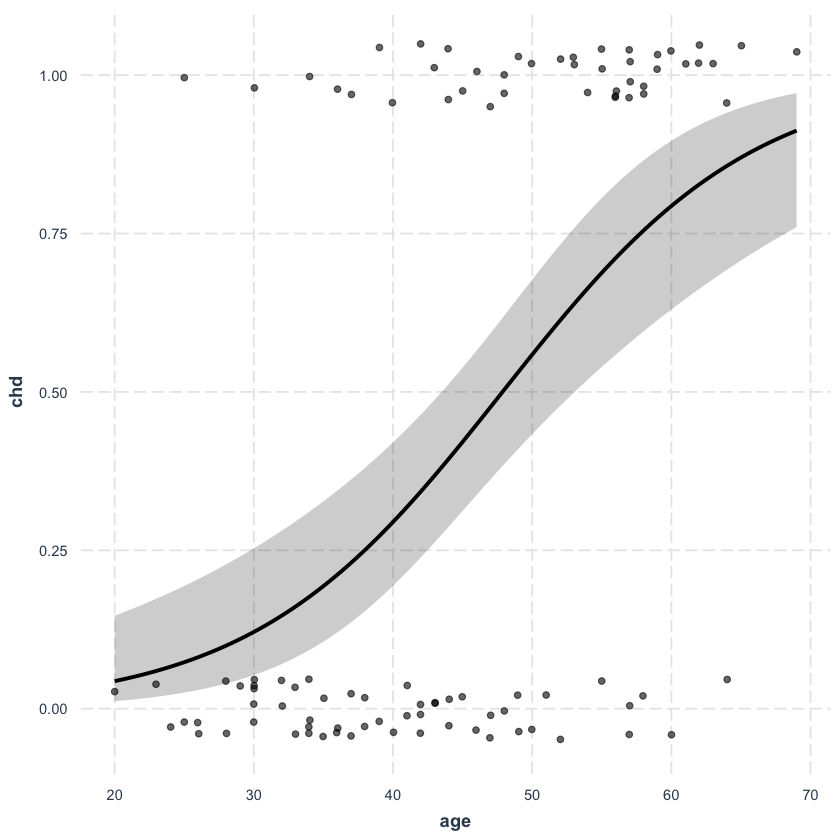

In [8]:
effect_plot(fm,
    pred = age, interval = TRUE, plot.points = TRUE,
    jitter = 0.05
)

## Considerazioni conclusive

Nel caso di una variabile dipendente binaria $Y_i$, il tradizionale modello di regressione lineare non può essere applicato. Tale problema può essere risolto applicando il modello
lineare non direttamente al valore atteso della variabile risposta, ma ad una sua trasformazione, il logit. La componente sistematica del modello di regressione lineare esprime il valore atteso della variabile dipendente come una funzione lineare dei predittori: $\mu_i = \boldsymbol{\beta x}_i$.

Per il modello di regressione lineare, il valore atteso di $Y$ è la media delle distribuzioni condizionate $Y \mid x_i$.

Per il modello di regressione logistica, il valore atteso della variabile risposta binaria, condizionato ad un determinato valore della variabile esplicativa (o ad un insieme di valori del vettore di variabili esplicative) è uguale alla probabilità che $Y$ assuma il valore 1:

$$
\mathbb{E}(Y \mid x_i) \equiv Pr(Y=1 \mid X=x_i) \equiv \pi_i.
$$

Tale valore atteso può essere interpretato come la proporzione di individui nella popolazione per i quali $Y=1$ in corrispondenza di $X=x_i$.

La componente sistematica del modello di regressione logistica rappresenta una trasformazione di $\pi_i$ come funzione lineare dei predittori:

$$
\ln \frac{\pi_i}{1-\pi_i} = \alpha + \beta X_i.
$$

Il modello \`e dunque lineare nei logit. Equivalentemente, esponenziando

$$
\frac{\pi_i}{1-\pi_i} = \exp(\alpha + \beta X_i)
$$

l'odds stimato di $Y_i=1$ \`e uguale a $\exp(\alpha + \beta X_i)$.

La funzione antilogit trasforma il predittore lineare $\eta_i = \alpha + \beta X_i$ nelle probabilità:

$$
\pi_i = \frac{\exp(\alpha+\beta X_i)}{1 + \exp(\alpha+\beta X_i)}.
$$

Il modello di regressione logistica è un modello non lineare nelle probabilità (ovvero, rispetto al valore atteso della variabile risposta).

La funzione logistica

$$
\Lambda(\eta) = \frac{\exp(\eta)}{1 + \exp(\eta)}
$$

viene  scelta quale funzione legame per trasformare la componente lineare del modello, $\eta_i =\alpha+\beta X_i$, nel valore atteso della variabile dipendente, $\pi_i$.
Qualunque funzione cumulativa di probabilità potrebbe fungere da funzione legame, tuttavia, è conveniente scegliere la funzione logistica per facilità di interpretazione.

La componente aleatoria del modello di regressione logistica, infine, ci porta a considerare la variabile dipendente come una variabile aleatoria binomiale, sia nel caso di dati raggruppati (con denomiatore binomiale uguale alla frequenza delle osservazioni in ciascun gruppo $n_i$ corrispondente a modalità omogenee della/e variabile/i esplicativa/e) che nel caso di dati individuali (dove $n_i$ = 1, $\forall i$).